# Import modules

In [1]:
import os
import cv2
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as T
import torchvision.models as models

import albumentations as A

from albumentations.pytorch import ToTensorV2
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler
from matplotlib import pyplot as plt
from scripts import dataloader
from scripts.dataloader_albumentations import *

# Check hardware accelerator
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Define hyperparameters

In [2]:
NUM_CLASSES = 2
EPOCHS = 100
BATCH_SIZE = 16

# Load Dataset

In [3]:
# Set data paths
TRAIN_DIR = '/home/pytholic/Desktop/Projects/datasets/window_detection/data_final/data_splitted/train/'
VAL_DIR = '/home/pytholic/Desktop/Projects/datasets/window_detection/data_final/data_splitted/val/'
ref_paths = glob.glob('/home/pytholic/Desktop/Projects/datasets/window_detection/data_final/histogram_ref_images/*')

classes = os.listdir(TRAIN_DIR)
print("Total Classes: ",len(classes))

#Counting total train, & test images

train_count = 0
val_count = 0

for _class in classes:
    train_count += len(os.listdir(TRAIN_DIR + _class))
    val_count += len(os.listdir(VAL_DIR + _class))

print("Total train images: ", train_count)
print("Total test images: ", val_count)

Total Classes:  2
Total train images:  9072
Total test images:  789


In [4]:
def get_train_transform():
    resize = A.Resize(224, 224)
    normalize = A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    bright_contrast = A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.2)
    rgb_shift = A.RGBShift(p=0.05)
    hue_sat = A.HueSaturationValue(p=0.05)
    channel_shuffle = A.ChannelShuffle(p=0.05)
    gamma = A.RandomGamma(p=0.05)
    gray = A.ToGray(p=0.05)
    jitter = A.ColorJitter(p=0.05)
    hor_flip = A.HorizontalFlip(p=0.1)
    histogram = A.HistogramMatching(reference_images = ref_paths, p=1.0)
    rotate = A.Rotate(limit=15, p=0.1)
    crop = A.RandomCrop(height=100, width=100, p=0.1)
    translate = A.Affine(translate_percent=0.1, p=0.1)
    shear = A.Affine(shear=20, p=0.05)
    scale = A.Affine(scale=1.2, p=0.1)
    to_tensor = ToTensorV2()
    #return A.Compose([resize, histogram, normalize, to_tensor])
    return A.Compose([histogram, resize, normalize, rgb_shift, hue_sat, jitter, gray, bright_contrast, 
                      hor_flip, rotate, translate, shear, scale, to_tensor])

def get_val_transform():
    resize = A.Resize(224, 224)
    normalize = A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    to_tensor = ToTensorV2()
    return A.Compose([resize, normalize, to_tensor])

In [5]:
train_dataset = CustomDataset(TRAIN_DIR, transforms=get_train_transform())
val_dataset = CustomDataset(VAL_DIR, transforms=get_val_transform())

print(len(train_dataset))
print(len(val_dataset))

9072
789


In [6]:
print(train_dataset[0][0].shape)
print(train_dataset[0][0])

torch.Size([3, 224, 224])
tensor([[[-0.8824, -0.8779, -0.8745,  ..., -0.8132, -0.8016, -0.7886],
         [-0.8824, -0.8817, -0.8766,  ..., -0.8468, -0.8277, -0.8064],
         [-0.8838, -0.8824, -0.8806,  ..., -0.8806, -0.8619, -0.8367],
         ...,
         [-0.8068, -0.8045, -0.8039,  ..., -0.8980, -0.8980, -0.8966],
         [-0.7975, -0.8004, -0.8022,  ..., -0.8980, -0.8980, -0.8980],
         [-0.7961, -0.7961, -0.7961,  ..., -0.8980, -0.8980, -0.8942]],

        [[-0.8786, -0.8755, -0.8757,  ..., -0.8480, -0.8380, -0.8315],
         [-0.8824, -0.8814, -0.8766,  ..., -0.8799, -0.8621, -0.8446],
         [-0.8838, -0.8824, -0.8762,  ..., -0.8954, -0.8848, -0.8654],
         ...,
         [-0.7941, -0.7953, -0.7917,  ..., -0.8924, -0.8910, -0.8887],
         [-0.7853, -0.7922, -0.7944,  ..., -0.8994, -0.8955, -0.8901],
         [-0.7884, -0.7909, -0.7897,  ..., -0.9029, -0.8985, -0.8978]],

        [[-0.8980, -0.8926, -0.8880,  ..., -0.8431, -0.8379, -0.8315],
         [-0.8980, 

In [7]:
print(train_dataset[0][0].min())
print(train_dataset[0][0].max())

tensor(0.)
tensor(0.9842)


In [8]:
train_data_loader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle=True)
val_data_loader = DataLoader(dataset = val_dataset, batch_size = BATCH_SIZE, shuffle=False)

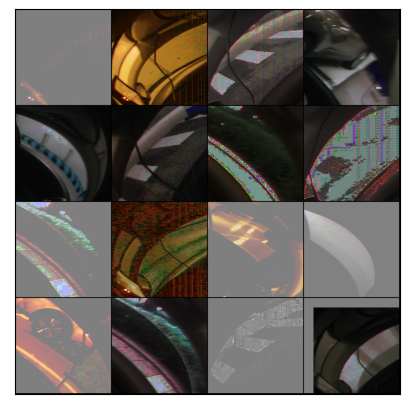

In [9]:
# Visualize one training batch
for images, labels in train_data_loader:
    fig, ax = plt.subplots(figsize = (5, 5))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4, normalize=True).permute(1,2,0), cmap='gray')
    break

# Training Pipeline

In [10]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)

device = set_device()
print(device)

cuda:0


## Training functions

In [11]:
# def accuracy(output, target):
#     with torch.no_grad():
#         #max_k = max(top_k)
#         batch_size = target.size(0)

#         _, pred = output.topk(1, 1, True, True)
#         pred = pred.t()
#         correct = pred.eq(target.view(1, -1).expand_as(pred))

#         correct_k = correct[:1].reshape(-1).float().sum(0, keepdim=True)
#         return correct_k.mul_(100.0 / batch_size)
    
# class AverageMeter:
#     def __init__(self):
#         self.num = 0
#         self.sum = 0
#         self.avg = 0

#     def update(self, v, n):
#         self.num = self.num + n
#         self.sum = self.sum + v * n
#         self.avg = self.sum / self.num

In [12]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    device = set_device()
    train_loss = []
    train_acc = []

    for epoch in range(num_epochs):
        #top1 = AverageMeter()
        print("Epoch number {}".format(epoch + 1))
        start = time.time()
        model.train()
        running_loss = 0.0
        running_correct = 0
        total = 0
      
        # Training
        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            #Reset Grads
            optimizer.zero_grad()

            #Forward ->
            outputs = model(images)

            # pred
            _, predicted = torch.max(outputs.data, 1)

            #Calculate Loss & Backward, Update Weights (Step)
            running_correct += (predicted == labels).sum().item()
            
            loss = criterion(outputs, labels)
            #loss = criterion(outputs.squeeze(), labels.unsqueeze(1).float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item() 
            #acc = accuracy(outputs, labels)
            #top1.update(acc.item(), labels.size(0))
            
    
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100.00 * running_correct / total

        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        
        #print(f"Accuracy: {top1.avg}")
        
        print("  - Training dataset: Got %d out of %d images correctly (%.3f%%). \nEpoch loss: %.3f"
            % (running_correct, total, epoch_acc, epoch_loss))

        val_acc = evaluate_model(model, val_loader)

        end = time.time()

        print("-  Epoch Time : {} \n".format(int(end-start)))

    print('Finished')
    return model, train_acc, train_loss, val_acc

In [13]:
# Validation function
def evaluate_model(model, val_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    best_acc = 0.0
    acc = []
    device = set_device()

    with torch.no_grad():
        for data in val_loader: 
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            predicted_correctly_on_epoch += (predicted == labels).sum().item()

    epoch_acc = 100.0 * predicted_correctly_on_epoch / total
    acc.append(epoch_acc)

    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), './model/model_new/best_model.pth')

    print("  - Testing dataset: Got %d out of %d images correctly (%.3f%%)"
        % (predicted_correctly_on_epoch, total, epoch_acc))

    return acc

## Model architecture

In [14]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 7)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.conv4 = nn.Conv2d(128, 256, 3)
        self.conv5 = nn.Conv2d(256, 512, 3)
        
        x = torch.randn(3, 224, 224).view(-1, 3, 224, 224)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, NUM_CLASSES)

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
#         if NUM_CLASSES == 2:
#             return F.sigmoid(x)
#         else:
#             return F.softmax(x, dim=1)

In [15]:
model = Net().to(device)
print(model)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=73728, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)


## Training

In [16]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [17]:
model_trained, TRAIN_LOSS, TRAIN_ACC, VAL_ACC = train_model(model, train_data_loader, val_data_loader, criterion, optimizer, lr_scheduler, num_epochs=EPOCHS)

Epoch number 1
  - Training dataset: Got 6535 out of 9072 images correctly (72.035%). 
Epoch loss: 0.541
  - Testing dataset: Got 633 out of 789 images correctly (80.228%)
-  Epoch Time : 239 

Epoch number 2
  - Training dataset: Got 7122 out of 9072 images correctly (78.505%). 
Epoch loss: 0.429
  - Testing dataset: Got 641 out of 789 images correctly (81.242%)
-  Epoch Time : 239 

Epoch number 3
  - Training dataset: Got 7436 out of 9072 images correctly (81.966%). 
Epoch loss: 0.364
  - Testing dataset: Got 658 out of 789 images correctly (83.397%)
-  Epoch Time : 238 

Epoch number 4
  - Training dataset: Got 7606 out of 9072 images correctly (83.840%). 
Epoch loss: 0.325
  - Testing dataset: Got 685 out of 789 images correctly (86.819%)
-  Epoch Time : 240 

Epoch number 5
  - Training dataset: Got 7765 out of 9072 images correctly (85.593%). 
Epoch loss: 0.284
  - Testing dataset: Got 659 out of 789 images correctly (83.523%)
-  Epoch Time : 244 

Epoch number 6
  - Training da

  - Training dataset: Got 8407 out of 9072 images correctly (92.670%). 
Epoch loss: 0.136
  - Testing dataset: Got 717 out of 789 images correctly (90.875%)
-  Epoch Time : 235 

Epoch number 44
  - Training dataset: Got 8421 out of 9072 images correctly (92.824%). 
Epoch loss: 0.132
  - Testing dataset: Got 746 out of 789 images correctly (94.550%)
-  Epoch Time : 235 

Epoch number 45
  - Training dataset: Got 8454 out of 9072 images correctly (93.188%). 
Epoch loss: 0.128
  - Testing dataset: Got 745 out of 789 images correctly (94.423%)
-  Epoch Time : 236 

Epoch number 46
  - Training dataset: Got 8402 out of 9072 images correctly (92.615%). 
Epoch loss: 0.138
  - Testing dataset: Got 727 out of 789 images correctly (92.142%)
-  Epoch Time : 236 

Epoch number 47
  - Training dataset: Got 8470 out of 9072 images correctly (93.364%). 
Epoch loss: 0.124
  - Testing dataset: Got 702 out of 789 images correctly (88.973%)
-  Epoch Time : 235 

Epoch number 48
  - Training dataset: Got

  - Testing dataset: Got 752 out of 789 images correctly (95.311%)
-  Epoch Time : 237 

Epoch number 86
  - Training dataset: Got 8545 out of 9072 images correctly (94.191%). 
Epoch loss: 0.110
  - Testing dataset: Got 737 out of 789 images correctly (93.409%)
-  Epoch Time : 236 

Epoch number 87
  - Training dataset: Got 8507 out of 9072 images correctly (93.772%). 
Epoch loss: 0.120
  - Testing dataset: Got 746 out of 789 images correctly (94.550%)
-  Epoch Time : 236 

Epoch number 88
  - Training dataset: Got 8499 out of 9072 images correctly (93.684%). 
Epoch loss: 0.110
  - Testing dataset: Got 737 out of 789 images correctly (93.409%)
-  Epoch Time : 237 

Epoch number 89
  - Training dataset: Got 8534 out of 9072 images correctly (94.070%). 
Epoch loss: 0.115
  - Testing dataset: Got 716 out of 789 images correctly (90.748%)
-  Epoch Time : 236 

Epoch number 90
  - Training dataset: Got 8520 out of 9072 images correctly (93.915%). 
Epoch loss: 0.112
  - Testing dataset: Got 

# Testing

In [46]:
from PIL import Image

classes = ['open', 'close']

In [48]:
model = Net()
state_dict = torch.load('./model/best_model_small.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [49]:
device = torch.device("cpu")
model.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=86528, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)

In [50]:
# Prediction function
def classify(model, image_transforms, images_path, classes):
    model = model.eval()
    cnt_correct = 0
    cnt_wrong = 0
    for image in os.listdir(images_path):
        label = str(image.split('/')[-1].split('_')[0])
        img = cv2.imread(os.path.join(images_path, image), 1)
        img = torch.from_numpy(img)
        img = img.permute(2, 0, 1)    
        img = img.unsqueeze(0)
        img = img.float()
        img = image_transforms(img)

        output = model(img)
        _, prediction = torch.max(output.data, 1)
        predicted_class = classes[prediction.item()]

        img = img.permute(0,2,3,1)
        img = img.numpy()
        img = img / 2 + 0.5  # denormalization
        plt.imshow((img[0]*255).astype('uint8'))
        plt.title(f'label: {label}, Prediction: {predicted_class}')
        plt.show()
        
        if label == predicted_class:
            cnt_correct += 1
        elif label != predicted_class:
            cnt_wrong += 1
            
    return cnt_correct, cnt_wrong

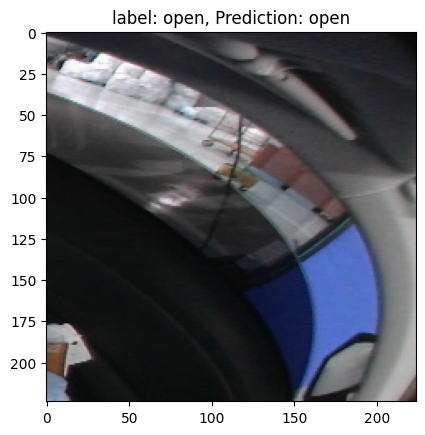

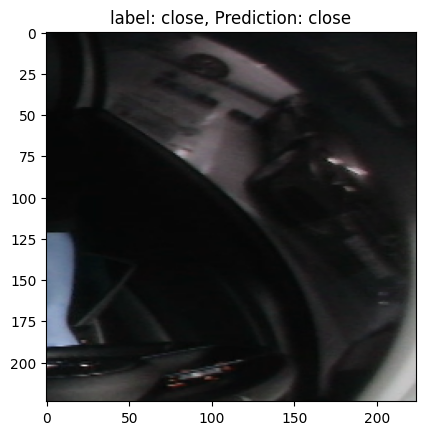

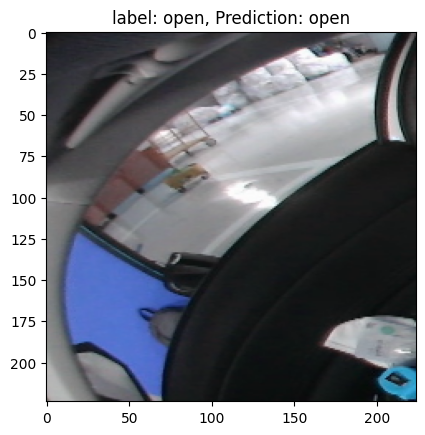

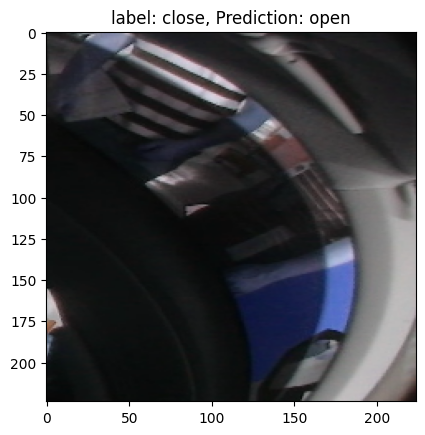

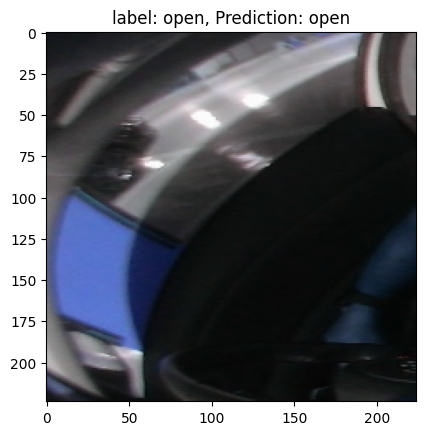

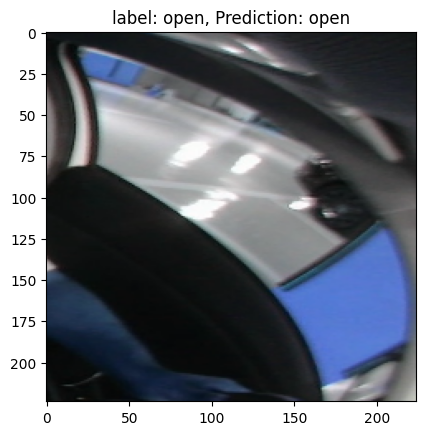

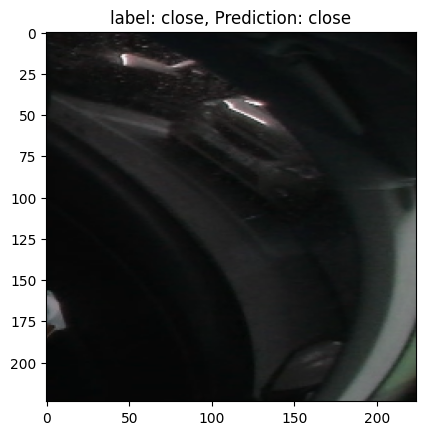

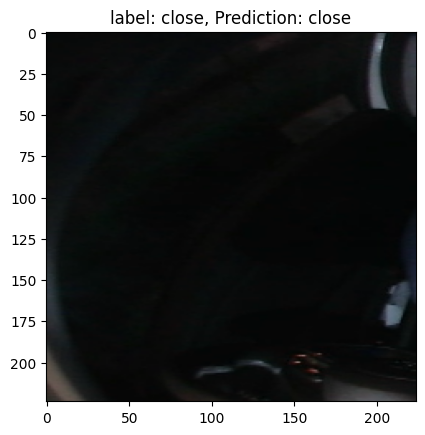

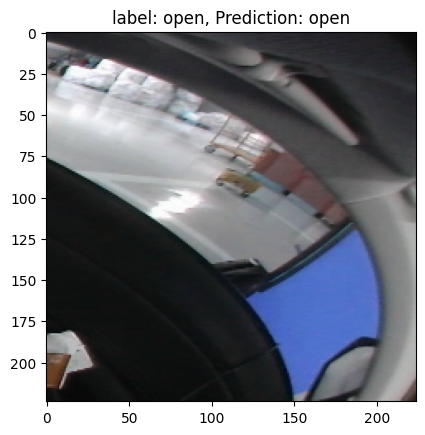

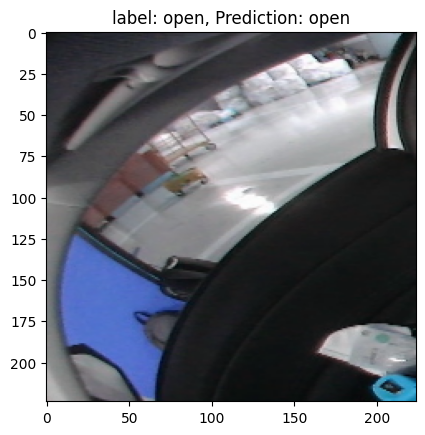

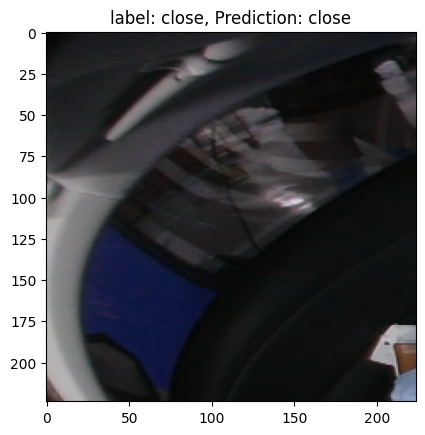

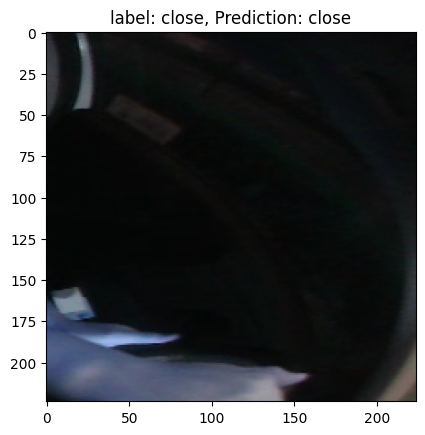

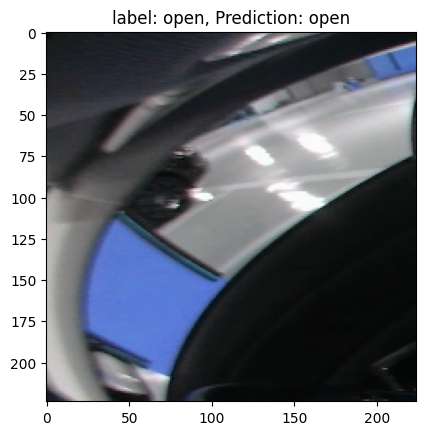

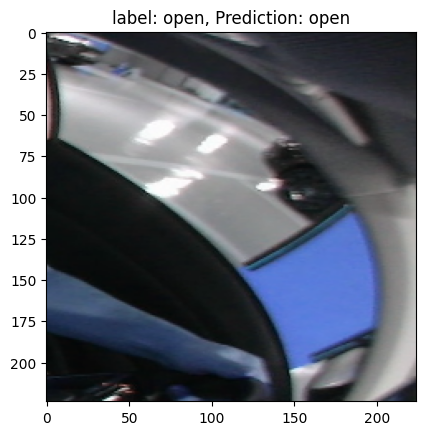

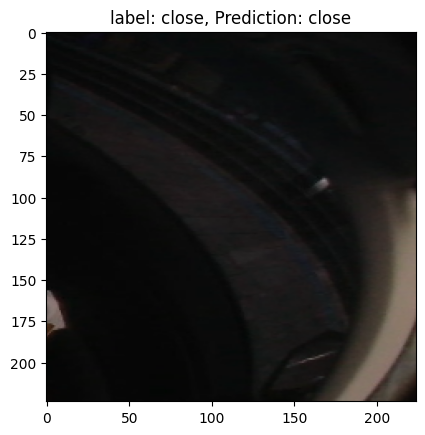

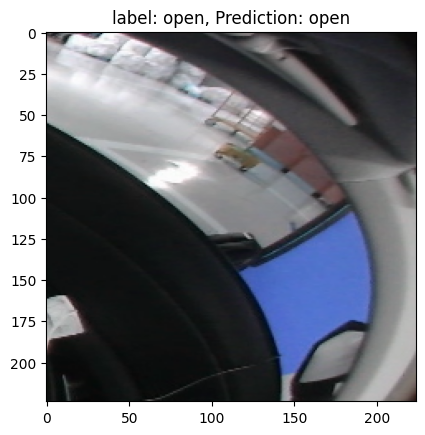

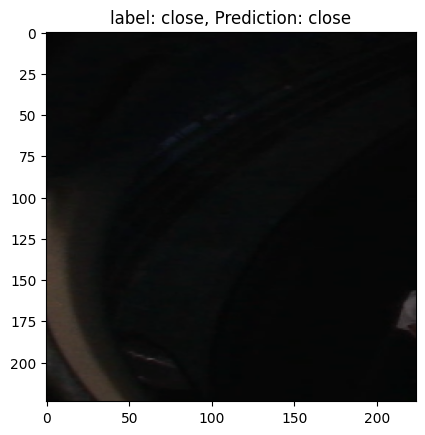

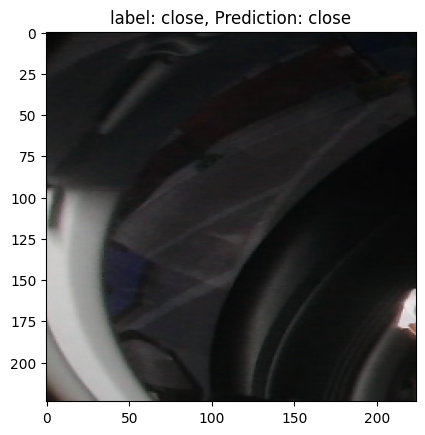

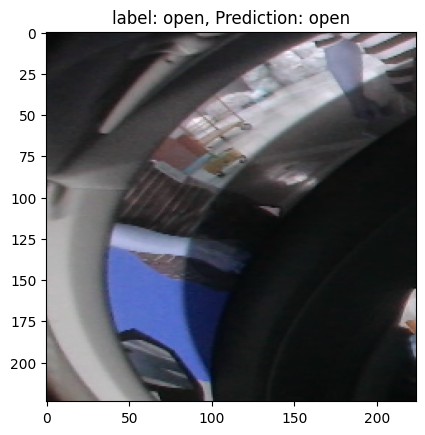

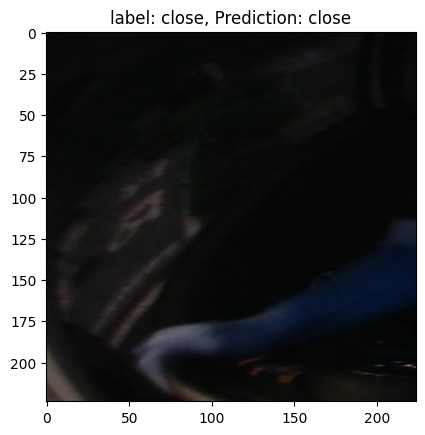

In [51]:
cnt_correct, cnt_wrong = classify(model, get_transform(), './data_final/test', classes)

In [52]:
print(f"Correct predictions: {cnt_correct}")
print(f"Wrong predictions: {cnt_wrong}")

Correct predictions: 19
Wrong predictions: 1
